<a href="https://colab.research.google.com/github/shubhh-eagle/shubhh-eagle/blob/main/cat_vs_non_cat_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat or no cat?

This notebook shows two simple image-recognition algorithms that can correctly classify pictures as cat or non-cat.  
The first is a classic logistic regression while the second - more accurate - is a deep neural network.

## 1 - Overview of the data set ##

The dataset is taken from Andrew Ng's course on Coursera *Introduction to Neural Networks*.  
The dataset ("data.h5") contains:
* a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
* a test set of m_test images labeled as cat or non-cat
* each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

Let's get more familiar with the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import h5py
    
    # Loading the data (cat/non-cat)
train_dataset = h5py.File('/content/drive/MyDrive/Colab Notebooks/train_catvnoncat.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

test_dataset = h5py.File('/content/drive/MyDrive/Colab Notebooks/test_catvnoncat.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
train_set_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

Each line of train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the `index` value and re-run to see other images. 

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (4.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

y = [1], it's a 'cat' picture.


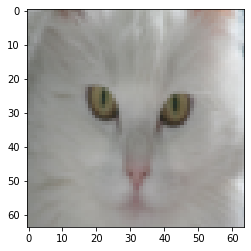

In [ ]:
    # Example of a picture
index = 50
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

## 2 - Data preprocessing

<font color='blue'>
**Dataset pre-processing:**

Common steps for pre-processing a new dataset are:
* Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
* Reshape the datasets such that each example is now a vector of size (num_px \* num_px \* 3, 1)
* "Standardize" the data

Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs. 

In [ ]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Dataset dimensions:")
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Dataset dimensions:
Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


For convenience, we now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.


A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is to use: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [ ]:
# Reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T 

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

<!-- During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures. !--> 

Let's standardize our dataset.

In [ ]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

## 3 - General Architecture of the learning algorithm ##

It's time to design a simple algorithm to distinguish cat images from non-cat images.  
The input will be the image transformed into a vector above, normlaised and flattened. The activation function is the sigmoid. If the output is more than 0.5 then it is considered a cat, otherwise not.  

![Logistic diagram to classify our cats images](../images/LogReg_kiank.png)

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b $$
$$y_{hat}^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$

Will use the *LogisticRegression* module from *sklearn*.   

**Key steps**:
* Initialize the parameters of the model
* Learn the parameters for the model by minimizing the cost  
* Use the learned parameters to make predictions (on the test set)
* Analyse the results and conclude

In [ ]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        t1 = classes[int(p[index])].decode("utf-8")
        t2 = classes[y[0,index]].decode("utf-8")
        plt.title("Prediction: " + t1 + " \n Class: " + t2)
        
    return num_images

# Deep Neural Network for Image Classification

Now we will build and apply a deep neural network to the problem.

## Dataset
We will use the same "Cat vs non-Cat" dataset as above. The model we had built had 72% test accuracy on classifying cats vs non-cats images. Hopefully, our new model will perform better!

y = 0. It's a non-cat picture.


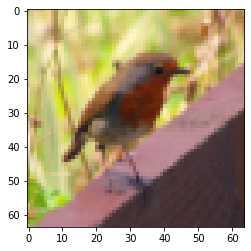

In [ ]:
# Example of a picture
index = 10
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[0,index]) + ". It's a " + classes[train_set_y[0,index]].decode("utf-8") +  " picture.")

## Building the parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) and the hyperparameters
1. Initialize the model's weights
1. Loop for the number of iterations:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)
1. Use the trained weights to predict the labels

## 4 - Defining the neural network structure

![Generic Neural Network](../images/nn.png)
We will define a deep network with a total of **five layers: input, output and three hidden layers**.  
Each layer has a different number of units.  
Defining the architecture of a neural network depends on the training data and the type of classification to perform and it is an art by itself.   Defining and re-fining the number of layers, units and all other parameters is called _hyperparameters tuning_ and we will see it in details in a next notebook.  
For the moment we hard-code an initial set of parameters.

![the architecture](../images/architecture.png)

<u>Detailed Architecture</u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$.    
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix W.
- You then add a bias term (the intercept b). the result is the linear unit.
- next, we take its ReLU (Rectified Linear Unit) to get the vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.  Each activation vector has a different size depending on the number of units  the layer.  
- The process is repeated for each hidden layer (in our case three times) and several times (number of iterations), each time calculating the loss and back-propagating appropriate changes in the weights until the wished loss is reached.  
- Finally, we take the sigmoid of the final linear unit. If it is greater than 0.5, we classify it to be a cat.

In [ ]:
### CONSTANTS DEFINING THE MODEL ####
n_x = train_set_x_flatten.shape[0]     # size of input layer
n_y = 1  # size of output layer, will be 0 or 1
    # we define a neural network with total 5 layers, x, y and 3 hidden:
    # the first hidden has 20 units, second has 7 units and third has 5
nn_layers = [n_x, 20, 7, 5, n_y]  # length is 5 (layers)

In [ ]:
nn_layers

[12288, 20, 7, 5, 1]

## 5 - Initializing parameters

There are two types of parameters to initialize in a neural network:
- the weight matrices $W^{[i]}$
- the bias vectors $b^{[i]}$

The weight matrix is initialised with random values while the bias vector as a vector of zeros.  
In general, initializing all the weights to zero results in the network failing to **break symmetry**. This means that every neuron in each layer will learn the same thing and the network is no more powerful than a linear classifier such as logistic regression.  

To break symmetry, we initialise the weights randomly. Following random initialisation, each neuron can then proceed to learn a different function of its inputs.  
Of course, different initializations lead to different results and poor initialisation can slow down the optimisation algorithm.  

One good practice is not to initialise to values that are too large, instead what bring good results are the so-called [Xavier](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) or the [He (for ReLU activation) initialisations](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf). 

### 5.1 - L-layer Neural Network

The initialization for an L-layer neural network is complicated because there are many weight matrices and bias vectors. Need to make sure that the dimensions match between each layer.

- The model's structure has $L-1$ layers using a ReLU activation function followed by an output layer with a sigmoid activation function.
- We will store $n^{[l]}$, the number of units in different layers, in a variable `layer_dims`. For example, a model with two inputs, one hidden layer with 4 hidden units and an output layer with 1 output unit would have dimensions equal to [2,4,1]. Thus means `W1`'s shape is (4,2), `b1` is (4,1), `W2` is (1,4) and `b2` is (1,1). 

In [ ]:
#  FUNCTION: initialize_parameters

def initialise_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
            # unit tests
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

How would look like that example network with 3 layers (of 2, 4 and 1 units) initialised?

In [ ]:
np.random.seed(3)
parameters = initialise_parameters([2,4,1])

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 1.26475132  0.30865908]
 [ 0.06823401 -1.31768833]
 [-0.19614308 -0.25085248]
 [-0.05850706 -0.44335643]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.02190908 -0.23860902 -0.65693238  0.44231119]]
b2 = [[0.]]


## 6 - Forward propagation module

Now that we have initialized our parameters, we will do the forward propagation module.  

![Feed Forward](../images/forward.png)

We will implement some helper functions and then put all together: 

- linear_forward:  implement the linear part, i.e. the $$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$$ equation, where $A^{[0]} = X$.
- linear_activation_forward: will add to the linear part the activation where activation will be either ReLU or Sigmoid. 
- L-model_forward: will call the [LINEAR -> RELU] $\times$ (L-1) times, finally the LINEAR -> SIGMOID


### 6.1 - Linear Forward 


In [ ]:
#  FUNCTION: linear_forward

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

A quick check:

In [ ]:
def linear_forward_test_case():
    np.random.seed(1)

    A = np.random.randn(3,2)
    W = np.random.randn(1,3)
    b = np.random.randn(1,1)
    
    Z, linear_cache = linear_forward(A, W, b)
    
    assert(round(Z[0][0], 5) ==  3.26295)
    assert(round(Z[0][1], 5) == -1.23430)

    return "OK"

In [ ]:
print(linear_forward_test_case())

OK


### 6.2 - Linear-Activation Forward

In this notebook, we will use two activation functions:

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$.  
This function returns **two** items: the activation value "`a`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it you could just call: 
``` python
A, activation_cache = sigmoid(Z)
```

- **ReLU**: The mathematical formula for ReLu is $A = RELU(Z) = max(0, Z)$.  
This function returns **two** items: the activation value "`A`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it you could just call:
``` python
A, activation_cache = relu(Z)
```

#### activation functions

In [ ]:
#  FUNCTION: sigmoid

def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

A quick black-box test for the sigmoid:

In [ ]:
def sigmoid_test_case():
    
    result, cache = sigmoid(np.array([0,2]))
                                
    assert(round(result[0], 5) ==  0.5)
    assert(round(result[1], 5) == 0.8808)

    return "OK"

In [ ]:
sigmoid_test_case()

'OK'

In [ ]:
def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


**Next**: Implement the forward propagation of the *LINEAR->ACTIVATION* layer.  
Mathematical relation is: $A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$ where the activation "g" can be sigmoid() or relu(). Use linear_forward() and the correct activation function.

In [ ]:
# FUNCTION: linear_activation_forward

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """

    Z, linear_cache = linear_forward(A_prev, W, b)

    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

As usual, a quick test:

In [ ]:
def linear_activation_forward_test_case():

    np.random.seed(2)

    A_prev = np.random.randn(3,2)
    W = np.random.randn(1,3)
    b = np.random.randn(1,1)
    
    A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "sigmoid")

    assert(round(A[0][0], 5) == 0.9689)
    assert(round(A[0][1], 5) == 0.11013)


    A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "relu")

    assert(round(A[0][0], 5) == 3.43896)
    assert(round(A[0][1], 5) == 0.0)


    return "OK"

In [ ]:
linear_activation_forward_test_case()

'OK'

**Note**: In deep learning, the "[LINEAR->ACTIVATION]" computation is counted as a single layer in the neural network, not two layers. 

###  L-Layer Model 

Now we put all together, using the helper functions:  
the (`linear_activation_forward` with RELU) $L-1$ times, then follows that with one `linear_activation_forward` with SIGMOID.


In [ ]:
#  FUNCTION: L_model_forward

def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        w_l = parameters['W' + str(l)] 
        b_l = parameters['b' + str(l)] 
        A, cache = linear_activation_forward(A_prev, w_l, b_l, activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    w_L = parameters['W' + str(L)] 
    b_L = parameters['b' + str(L)] 
    Yhat, cache = linear_activation_forward(A, w_L, b_L, activation = "sigmoid")
    caches.append(cache)
    
    assert(Yhat.shape == (1,X.shape[1]))
            
    return Yhat, caches

In [ ]:
def L_model_forward_test_case():
    np.random.seed(6)
    X = np.random.randn(5,4)
    W1 = np.random.randn(4,5)
    b1 = np.random.randn(4,1)
    W2 = np.random.randn(3,4)
    b2 = np.random.randn(3,1)
    W3 = np.random.randn(1,3)
    b3 = np.random.randn(1,1)
  
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    AL, caches = L_model_forward(X, parameters)

    np.testing.assert_array_almost_equal(AL, [[0.03922,  0.704989,  0.19734,  0.04728]], decimal=5)
    assert(len(caches) == 3)

    return "OK"


In [ ]:
L_model_forward_test_case()

'OK'

Great! Now we have a full forward propagation that takes the input X and outputs a row vector $A^{[L]}$ containing our predictions. It also records all intermediate values in "caches". Using $A^{[L]}$, we can compute the cost of our predictions.

## 7 - Cost function

Now we need to compute the cost, because we want to check if our model is actually learning.

**Next**: Compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$


In [ ]:
#  FUNCTION: compute_cost

def compute_cost(Yhat, Y):
    """
    Implement the cross-entropy cost function

    Arguments:
    Yhat -- probability vector corresponding to the label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

        # Compute loss from AL and Y.
    logprobs = np.dot(Y, np.log(Yhat).T) + np.dot((1-Y), np.log(1-Yhat).T)

    cost = (-1./m) * logprobs 

    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [ ]:
def compute_cost_test_case():
    y = np.asarray([[1, 1, 1]])
    al = np.array([[.8,.9,0.4]])
    
    cost = compute_cost(al, y)
    
    #assert(cost == 0.41493)
    np.testing.assert_approx_equal(cost, 0.41493, significant=5)
    
    return "OK"

In [ ]:
compute_cost_test_case()

'OK'

## 8 - Backward propagation module

Now we will implement the backward function for the whole network.  

![Backward pass](../images/backward.png) 

Just like with forward propagation, we will implement helper functions for backpropagation. Remember that back propagation is used to calculate the gradient of the loss function with respect to the parameters. 
You can see more about backpropagation in my previous post: 


Now, similar to forward propagation, we are going to build the backward propagation in three steps:
- linear backward
- LINEAR -> ACTIVATION backward where ACTIVATION computes the derivative of either the ReLU or sigmoid activation
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID backward (whole model)

**Reminder**: 
![Forward and Backward propagation for LINEAR->RELU->LINEAR->SIGMOID](../images/backprop_kiank.png)

_The purple blocks represent the forward propagation, and the red blocks represent the backward propagation._

### 8.1 - Linear backward

For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Now we need to compute the three derivatives $(dW^{[l]}, db^{[l]}, dA^{[l]})$, using as input a known derivate $dZ^{[l]}  = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. :


$$ dW^{[l]} = \frac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} $$
$$ db^{[l]} = \frac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} $$

In [ ]:
#  FUNCTION: linear_backward

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1./m) * np.dot(dZ, A_prev.T)
    db = (1./m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [ ]:
def linear_backward_test_case():

    np.random.seed(1)

    dZ = np.random.randn(1,2)
    
    A = np.random.randn(3,2)
    W = np.random.randn(1,3)
    b = np.random.randn(1,1)
    
    linear_cache = (A, W, b)
    
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    np.testing.assert_array_almost_equal(dA_prev, [[ 0.51823, -0.19517], [-0.40506,  0.15255], [ 2.37496, -0.89445]], decimal=5)
    np.testing.assert_array_almost_equal(dW, [[-0.10077,  1.40685,  1.64992]], decimal=5)
    np.testing.assert_approx_equal(db, 0.50629, significant=5)


    
    return "OK"

In [ ]:
linear_backward_test_case()

'OK'

### 8.2 - Linear-Activation backward

Next, we will create a function that merges the two helper functions: **`linear_backward`** and the backward step for the activation: 

- **`sigmoid_backward`**: Implements the backward propagation for SIGMOID unit. 

- **`relu_backward`**: Implements the backward propagation for RELU unit. 

If $g(.)$ is the activation function, 
`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}) \tag{11}$$.  


In [ ]:
def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


In [ ]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [ ]:
#  FUNCTION: linear_activation_backward

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [ ]:
def linear_activation_backward_test_case():

    np.random.seed(2)

    dA = np.random.randn(1,2)
    A = np.random.randn(3,2)
    W = np.random.randn(1,3)
    b = np.random.randn(1,1)
    Z = np.random.randn(1,2)
    
    linear_cache = (A, W, b)
    activation_cache = Z
    linear_activation_cache = (linear_cache, activation_cache)
    
    dA_prev, dW, db = linear_activation_backward(dA, linear_activation_cache, activation = "sigmoid")
    
    np.testing.assert_array_almost_equal(dA_prev, [[0.11018,  0.01105], [ 0.09467,  0.00949], [-0.05743, -0.00576]], decimal=5)
    np.testing.assert_approx_equal(db, -0.057296, significant=5)
    np.testing.assert_array_almost_equal(dW, [[ 0.10267,  0.09778, -0.01968]] , decimal=5)

    
    dA_prev, dW, db = linear_activation_backward(dA, linear_activation_cache, activation = "relu")


    np.testing.assert_array_almost_equal(dA_prev, [[ 0.4409,  0.], [ 0.37884,  0. ], [-0.22982, 0. ]] , decimal=5)
    np.testing.assert_array_almost_equal(dW, [[ 0.44514,  0.37371, -0.10479]] , decimal=5)
    np.testing.assert_approx_equal(db, -0.20838, significant=5)
    
    return "OK"

In [ ]:
linear_activation_backward_test_case()

'OK'

### 8.3 - L-Model Backward 

Recall that when we implemented the `L_model_forward` function, at each iteration, we stored a cache which contains (X,W,b, and z). In the back propagation module, we will use those variables to compute the gradients. Therefore, in the `L_model_backward` function, we will iterate through all the hidden layers backward, starting from layer $L$. On each step, we will use the cached values for layer $l$ to backpropagate through layer $l$. 



In [ ]:
#  FUNCTION: L_model_backward

def L_model_backward(Yhat, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = Yhat.shape[1]
    Y = Y.reshape(Yhat.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, Yhat) - np.divide(1 - Y, 1 - Yhat)) # derivative of cost with respect to AL
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 2)], caches". Outputs: "grads["dA" + str(l + 1)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [ ]:
def L_model_backward_test_case():

    np.random.seed(3)
    AL = np.random.randn(1, 2)
    Y = np.array([[1, 0]])

    A1 = np.random.randn(4,2)
    W1 = np.random.randn(3,4)
    b1 = np.random.randn(3,1)
    Z1 = np.random.randn(3,2)
    linear_cache_activation_1 = ((A1, W1, b1), Z1)

    A2 = np.random.randn(3,2)
    W2 = np.random.randn(1,3)
    b2 = np.random.randn(1,1)
    Z2 = np.random.randn(1,2)
    linear_cache_activation_2 = ((A2, W2, b2), Z2)

    caches = (linear_cache_activation_1, linear_cache_activation_2)
    
    grads = L_model_backward(AL, Y, caches)
    
    np.testing.assert_array_almost_equal(grads["dW1"], [[ 0.4101, 0.078072, 0.13798, 0.10502], [ 0., 0., 0., 0. ], [0.05284, 0.01006, 0.01778, 0.01353]] , decimal=5)
    np.testing.assert_array_almost_equal(grads["db1"], [[-0.22007], [ 0.], [-0.02835]], decimal=5)
    np.testing.assert_array_almost_equal(grads["dA2"], [[ 0.12913, -0.44014], [-0.14176,0.48317], [0.01664, -0.05671]], decimal=5)

    return "OK"

In [ ]:
L_model_backward_test_case()

'OK'

### 8.4 - Update Parameters

In this section we will update the parameters of the model, using gradient descent: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$

where $\alpha$ is the learning rate. After computing the updated parameters, we store them in the parameters dictionary. 

In [ ]:
#  FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

In [ ]:
def update_parameters_test_case():
    np.random.seed(2)
    W1 = np.random.randn(3,4)
    b1 = np.random.randn(3,1)
    W2 = np.random.randn(1,3)
    b2 = np.random.randn(1,1)
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    np.random.seed(3)
    dW1 = np.random.randn(3,4)
    db1 = np.random.randn(3,1)
    dW2 = np.random.randn(1,3)
    db2 = np.random.randn(1,1)
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    parameters = update_parameters(parameters, grads, 0.1)
    
    np.testing.assert_array_almost_equal(parameters["W1"], [[-0.59562, -0.09992, -2.14585, 1.82662], [-1.7657, -0.80627, 0.51116, -1.18259,], [-1.05357,  -0.86129,  0.68284,  2.20375]] , decimal=5)
    np.testing.assert_array_almost_equal(parameters["b1"], [[-0.04659], [-1.28888], [ 0.53405]], decimal=5)
    np.testing.assert_array_almost_equal(parameters["W2"], [[-0.55569,  0.0354, 1.32964]], decimal=5)
    np.testing.assert_array_almost_equal(parameters["b2"], [[-0.8461]], decimal=5)
    
    return "OK"

In [ ]:
update_parameters_test_case()

'OK'

## 9 - L-layer Neural Network

Now we can put together all the functions to build an L-layer neural network with this structure:

In [ ]:
nn_layers

[12288, 20, 7, 5, 1]

In [ ]:
#  FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0076, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialise_parameters(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

You will now train the model as a 5-layer neural network.
Run the cell below to train your model. The cost should decrease on every iteration. It may take up to 5 minutes to run 2500 iterations. If the cost is not decreasing, then you can click on the square (⬛) on the upper bar of the notebook to stop the cell and try to find your error.

In [ ]:
np.random.seed(1)

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.671866
Cost after iteration 200: 0.651173
Cost after iteration 300: 0.620546
Cost after iteration 400: 0.575133
Cost after iteration 500: 0.509820
Cost after iteration 600: 0.455846
Cost after iteration 700: 0.415171
Cost after iteration 800: 0.355023
Cost after iteration 900: 0.352762
Cost after iteration 1000: 0.270957
Cost after iteration 1100: 0.223042
Cost after iteration 1200: 0.192006
Cost after iteration 1300: 0.163800
Cost after iteration 1400: 0.143914
Cost after iteration 1500: 0.128439
Cost after iteration 1600: 0.115113
Cost after iteration 1700: 0.104458
Cost after iteration 1800: 0.095819
Cost after iteration 1900: 0.090647
Cost after iteration 2000: 0.084630
Cost after iteration 2100: 0.075587
Cost after iteration 2200: 0.070486
Cost after iteration 2300: 0.068854
Cost after iteration 2400: 0.063440


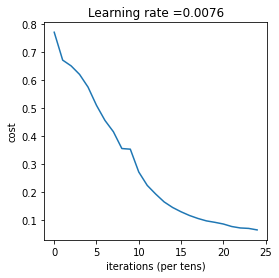

In [ ]:
fit_params = L_layer_model(train_set_x, train_set_y, nn_layers, num_iterations = 2500, print_cost = True)

## 10. Results analysis

Now we can check the performance of the trained network by predicting the results of the test set and comparing them with the actual labels.

In [ ]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probs to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    # print results
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [ ]:
pred_train = predict(train_set_x, train_set_y, fit_params)

Accuracy: 0.9952153110047844


In [ ]:
pred_test = predict(test_set_x, test_set_y, fit_params)

Accuracy: 0.8200000000000001


Congrats! It seems that this 5-layer neural network has **better performance (80%)** than the logistic regression model (72%) on the same test set. 

This is good performance for this task. 

Even higher accuracy could be obtained, by systematically searching for better hyperparameters (learning_rate, layers_dims, num_iterations) and other techniques such as regularisation, that we can see in the next notebook. 

With logistic regression we had 14 misses in the test set, out of 50.  
Let's check how many we have now and which ones are.

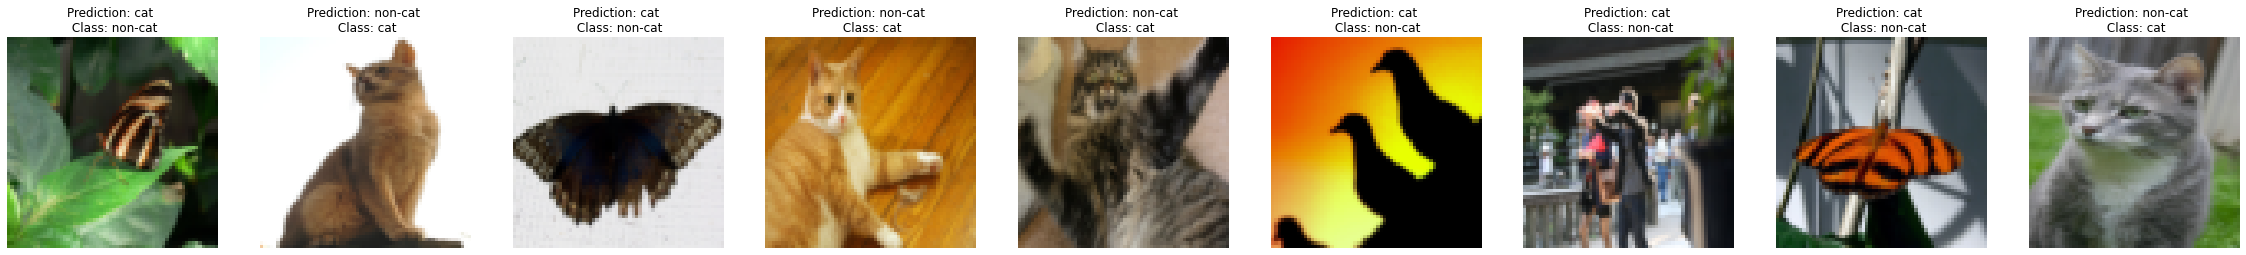

In [ ]:
misses = print_mislabeled_images(classes, test_set_x, test_set_y, pred_test[0])

In [ ]:
print("Number of misses: {0}".format(misses))

Number of misses: 9


### 3.3 - Test with your own image 

You can use your own image and see the output of the model. To do that:
1. Clone the repository.
1. Click on "File" in the upper bar of this notebook, then click "Open".
1. Add your image to the Jupyter Notebook's directory, in the "images" folder
1. Change your image's name in the following code
1. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

In [ ]:
print('''Enter name of image file, that you want to predict whether it is cat or not cat..
        format of filename example = cat.png  ''')

image_filename = input("filename: ")

Enter name of image file, that you want to predict whether it is cat or not cat..
        format of filename example = cat.png  
filename: cat.jpg


In [ ]:
# We preprocess the image to fit the LR algorithm.
from numpy import asarray
from PIL import Image

fname = '/content/drive/MyDrive/Colab Notebooks/' + str(image_filename)
#image = np.array(scipy.ndimage.imread(cat.jpg, flatten=False))

#im = np.array(Image.open(fname)) #you can pass multiple arguments in single line
original_image = Image.open(fname)
image = original_image.resize(size = (num_px,num_px),resample = 0)
data = asarray(image)
data = data.reshape(1,num_px*num_px*3).T
print(data.shape)

#my_image = scipy.imresize(im, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T


(12288, 1)


Accuracy: 1.0
y = 1.0, the algorithm predicts a "cat" picture.


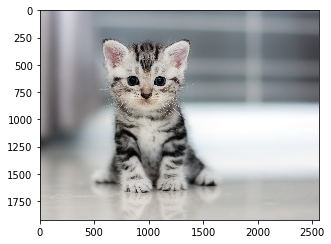

In [ ]:
my_predicted_image = predict(data, [1], fit_params)
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.imshow(original_image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", the algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

Bibliography:
- [Andrew Ng's deep learning course](https://www.deeplearning.ai/)
- [Tutorial: implement a neural network from scratch](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/)
- [Image normalisation](https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c)